### Importing libraries & data.

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
# from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches

from scipy.stats import gaussian_kde

from numpy.polynomial.chebyshev import Chebyshev
import numpy as np

from rich.console import Console
from rich.table import Table

from multiprocessing import Pool, cpu_count

import functions

import constants

### Do we save the plots ?
SAVEFIG = False

### Defining functions (vectorized).

In [2]:
def omega_m(z, omega_0):
    z = np.asarray(z)
    omega_0 = np.asarray(omega_0)
    return omega_0 * (1 + z)**3 / (omega_0 * (1 + z)**3 + 1 - omega_0)

def g(z, omega_0, omega_l0=0.7):
    omz = omega_m(z, omega_0)
    olz = 1 - omz
    return 2.5 * omz / (omz**(4/7) - olz + (1 + omz/2)*(1 + olz/70))

def D(z, omega_0, omega_l0=0.7):
    return g(z, omega_0, omega_l0) / g(0, omega_0, omega_l0) / (1 + np.asarray(z))

def gamma(omega_m_z):
    omega_m_z = np.asarray(omega_m_z)
    return 6/11 - 15/2057 * np.log(omega_m_z)

def sigma_8(z, omega_0, sigma_8_0):
    return sigma_8_0 * D(z, omega_0)

def f(gamma_func, z, omega_0):
    omega_m_z = omega_m(z, omega_0)
    return omega_m_z ** gamma_func(omega_m_z)

def growth(z, gamma_func = gamma, omega_0 = constants.OMEGA_0, sigma_8_0 = constants.SIGMA_8_0):
    """Returns linear growth rate according to the redshift.

    Args:
        z (float): redshift
        fun_gamma (γ): gamma. Defaults to gamma.
        omega_0 (float): Ωm(0). Defaults to constants.OMEGA_0.
        sigma_8_0 (float): σ8(0). Defaults to constants.SIGMA_8_0.

    Returns:
        float: fσ8(z)
    """
    return f(gamma_func, z, omega_0) * sigma_8(z, omega_0, sigma_8_0)

def display(res):
    """Displays results as a table. 

    Args:
        res (table): [t1, t2, ...] with ti = [name, value, error]
    """
    console = Console()
    table = Table(title="Results")

    table.add_column("Variable name", justify="center")
    table.add_column("Value", justify="center")
    table.add_column("Error", justify="center")

    for row in res:
        table.add_row(row[0], f"{row[1]:.3f}", "-" if row[2]=="-" else f"{row[2]:.3f}")
        
    console.print(table)

### Plotting growth data.

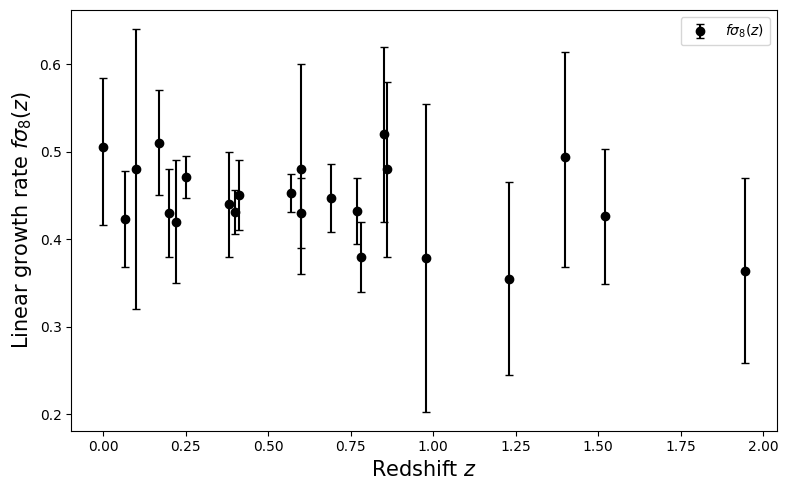

In [3]:
plt.figure(figsize=(8, 5))

plt.errorbar(constants.z_data, constants.fs8_data, yerr=constants.fs8_err, fmt='o', color='black', label=r"$f\sigma_8(z)$", capsize=3)

plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$", fontsize=15)
plt.grid(False)
plt.legend()

plt.tight_layout()
if SAVEFIG:
    plt.savefig("figure1.png", dpi=300)

plt.show()

### Plotting theoretical linear growth rate with $3\sigma$ bootstrap envelope.

                     Results                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃        Variable name         ┃ Value  ┃ Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│              χ²              │ 15.107 │   -   │
│            χ²/ddl            │ 0.657  │   -   │
│           p-value            │ 0.891  │   -   │
│ Écart-type moyen des données │ 0.075  │   -   │
│    Écart-type des résidus    │ 0.048  │   -   │
└──────────────────────────────┴────────┴───────┘

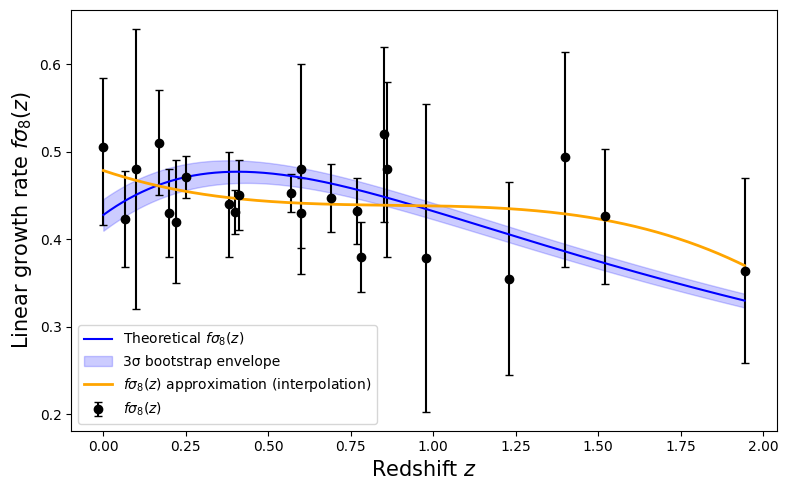

In [ ]:
from scipy.stats import chi2
from scipy.interpolate import UnivariateSpline

def print_infos_chi2(z_values, data, err_plus, err_minus):
    theo = growth(z_values)
    errors = 0.5 * (err_plus + err_minus)
    chi2_val = np.sum((data - theo)**2 / errors**2)
    ddl = len(data)
    p_value = 1 - chi2.cdf(chi2_val, ddl)

    results = [["χ²", chi2_val, "-"], 
           ["χ²/ddl", chi2_val/ddl, "-"], 
           ["p-value", p_value, "-"], 
           ["Écart-type moyen des données", np.mean(errors), "-"],
           ["Écart-type des résidus", np.std(data - theo), "-"]]
    display(results)

### Number of points for theoretical growth function plot
nb_points_th = 1000
z_range = np.linspace(min(constants.z_data), max(constants.z_data), nb_points_th)

### Bootstrap
nb_draw = 1000
fsigma8_results_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(constants.OMEGA_0, constants.OMEGA_0_SIGMA)
    sigma8_0 = np.random.normal(constants.SIGMA_8_0, constants.SIGMA_8_0_SIGMA)
    fsigma8_results_boot[i, :] = growth(z_range, omega_0 = omega0, sigma_8_0 = sigma8_0)

fsigma8_mean, fsigma8_std = np.mean(fsigma8_results_boot, axis=0), np.std(fsigma8_results_boot, axis=0)

### Chi2
print_infos_chi2(constants.z_data.values, constants.fs8_data, constants.fs8_err_plus, constants.fs8_err_minus)

### Approximation
# spline = UnivariateSpline(constants.z_data, constants.fs8_data, s=len(constants.fs8_data))
# fs8_approx = spline(z_range)

### Plotting
plt.figure(figsize=(8, 5))
# Data distribution
plt.errorbar(constants.z_data, constants.fs8_data, yerr=constants.fs8_err, fmt='o', color='black', label=r"$f\sigma_8(z)$", capsize=3)
# Theoretical function
growth_values = growth(z_range)
plt.plot(z_range, growth_values, color='blue', label=r"Theoretical $f\sigma_8(z)$")
# Enveloppe
plt.fill_between(z_range, fsigma8_mean-3*fsigma8_std, fsigma8_mean+3*fsigma8_std, color='blue', alpha=0.2, label='3σ bootstrap envelope')
# Approximate function
plt.plot(z_range, fs8_approx, color='orange', lw=2, label=r"$f\sigma_8(z)$ approximation (interpolation)")
# Labels
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$", fontsize=15)
plt.grid(False)
plt.legend()
plt.tight_layout()

if SAVEFIG:
    plt.savefig("figure2.png", dpi=300)

plt.show()

### Plotting theoretical $f\sigma_8(z)$ and polynomial approximations.

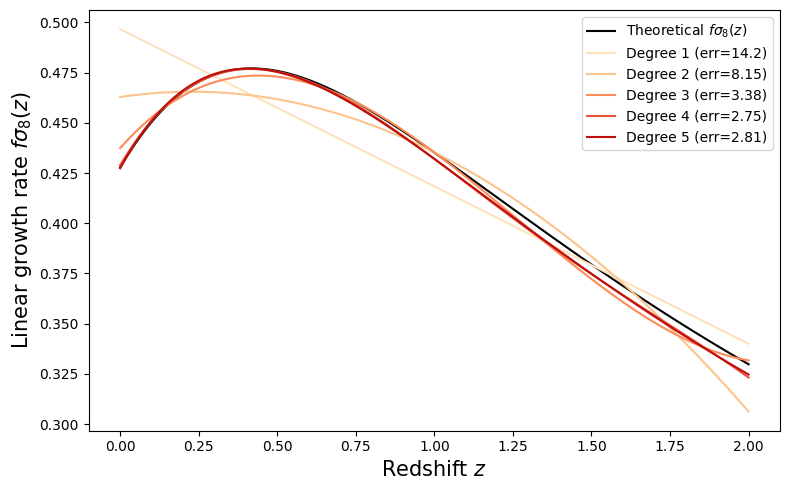

In [6]:
### Max polynomial degree
N = 5
domain = [0, 2]
z_dense = np.linspace(domain[0], domain[1], nb_points_th)
f_dense = growth(z_dense)

plt.figure(figsize=(8, 5))
plt.plot(z_dense, growth_values, color='black', label=r"Theoretical $f\sigma_8(z)$")

### For colors
norm = Normalize(vmin=0, vmax=N+1)
cmap = plt.get_cmap('OrRd')

for n in range(1, N+1):
    cheb_poly = Chebyshev.fit(z_dense, f_dense, deg=n, domain=domain)

    err = 0
    for i in range(nb_points_th):
        err += abs(cheb_poly(z_dense[i]) - growth_values[i])
    
    color = cmap(norm(n))
    plt.plot(z_dense, cheb_poly(z_dense),
             color=color,
             label=f'Degree {n} (err={round(err, 2)})')

plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$", fontsize=15)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

if SAVEFIG:
    plt.savefig("figure3.png", dpi=300)

# 1) $(\sigma_8, \Omega_m)$ & $(S_8, \Omega_m)$

### Defining functions.

In [7]:
def calc_chi2_sigma_omega(omega0, sigma8_0):
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    chi2 = np.sum((growth(z_data.values, omega_0=omega0, sigma_8_0=sigma8_0) - fs8_data)**2 / errors**2)
    return chi2

def calc_chi2_sigma_omega_vectorized(omega0, sigma8_0):
    omega0 = np.asarray(omega0)
    sigma8_0 = np.asarray(sigma8_0)
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    
    model = growth(z_data.values, omega_0=omega0[..., None], sigma_8_0=sigma8_0[..., None])
    residuals = (model - fs8_data) / errors
    chi2 = np.sum(residuals**2)
    return chi2

def calc_chi2_s8_omega_vectorized(omega0, s8):
    return calc_chi2_sigma_omega_vectorized(omega0, s8 * np.sqrt(0.3/omega0))

def mcmc_metropolis_hastings(n_steps, initial_params, proposal_widths, calc_chi2_func):
    current_omega_m, current_sigma8 = initial_params
    chain = np.zeros((n_steps, 2))
    current_chi2 = calc_chi2_func(current_omega_m, current_sigma8)
    
    for i in range(n_steps):
        proposed_omega_m = np.random.normal(current_omega_m, proposal_widths[0])
        proposed_sigma8 = np.random.normal(current_sigma8, proposal_widths[1])
        
        # Physical constraints
        if not (0 < proposed_omega_m < 1 and 0 < proposed_sigma8 < 2):
            chain[i] = [current_omega_m, current_sigma8]
            continue
        
        proposed_chi2 = calc_chi2_func(proposed_omega_m, proposed_sigma8)
        
        delta_chi2 = proposed_chi2 - current_chi2
        acceptance_prob = np.exp(-0.5 * delta_chi2)
        
        if np.random.rand() < acceptance_prob:
            current_omega_m, current_sigma8 = proposed_omega_m, proposed_sigma8
            current_chi2 = proposed_chi2
        
        chain[i] = [current_omega_m, current_sigma8]
    
    return chain

def run_single_chain(seed, calc_chi2_func):
    np.random.seed(seed)
    return mcmc_metropolis_hastings(
        n_steps=n_steps // n_chains,
        initial_params=[0.3 + 0.01*np.random.randn(), 0.8 + 0.01*np.random.randn()],
        proposal_widths=proposal_widths,
        calc_chi2_func=calc_chi2_func
    )

def run_single_chain_sigma_omega(seed):
    return run_single_chain(seed, calc_chi2_sigma_omega_vectorized)

def run_single_chain_s8_omega(seed):
    return run_single_chain(seed, calc_chi2_s8_omega_vectorized)


### Plotting distributions.

             Results             
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│      Ωₘ       │ 0.356 │ 0.060 │
│      σ₈       │ 0.758 │ 0.032 │
└───────────────┴───────┴───────┘

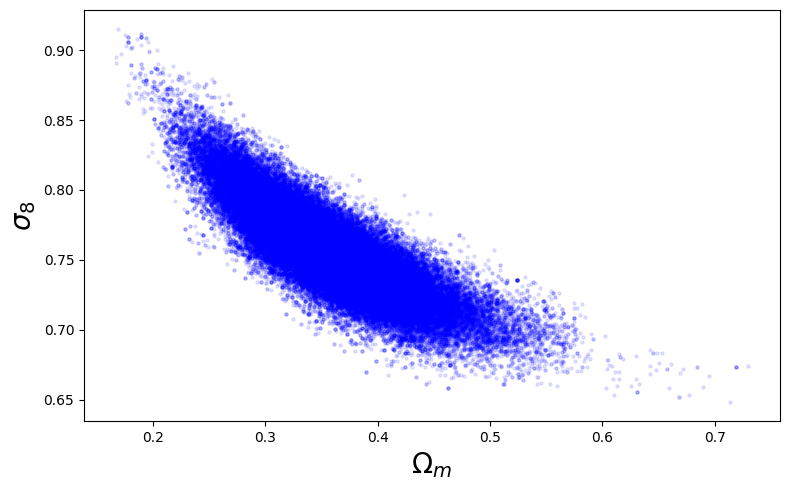

             Results             
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│      Ωₘ       │ 0.362 │ 0.062 │
│      S₈       │ 0.825 │ 0.044 │
└───────────────┴───────┴───────┘

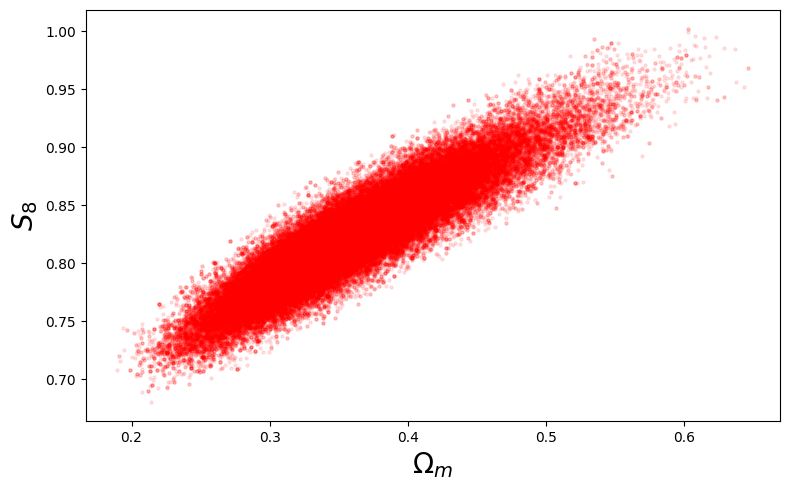

In [8]:
n_steps = 10000 * 10
n_chains = min(cpu_count(), 8)
proposal_widths = [0.02, 0.01]

### (sigma_8, Omega_m)
# Parallelization
with Pool(n_chains) as pool:
    chains = pool.map(run_single_chain_sigma_omega, range(n_chains))

chain_all = np.vstack(chains)
burn_in = 1000
chain_clean = chain_all[burn_in:]

omega_m_mean = np.mean(chain_clean[:, 0])
sigma8_mean = np.mean(chain_clean[:, 1])

results = [["Ωₘ", omega_m_mean, np.std(chain_clean[:, 0])], 
           ["σ₈", sigma8_mean, np.std(chain_clean[:, 1])]]
display(results)

plt.figure(figsize=(8, 5))
plt.scatter(chain_clean[:, 0], chain_clean[:, 1], s=5, alpha=0.1, c='blue')
plt.xlabel(r"$\Omega_m$", fontsize=20)
plt.ylabel(r"$\sigma_8$", fontsize=20)
plt.grid(False)
plt.tight_layout()

plt.show()

### (S_8, Omega_m)
# Parallelization
with Pool(n_chains) as pool:
    chains = pool.map(run_single_chain_s8_omega, range(n_chains))

chain_all = np.vstack(chains)
burn_in = 1000
chain_clean = chain_all[burn_in:]

omega_m_mean = np.mean(chain_clean[:, 0])
sigma8_mean = np.mean(chain_clean[:, 1])

results = [["Ωₘ", omega_m_mean, np.std(chain_clean[:, 0])], 
           ["S₈", sigma8_mean, np.std(chain_clean[:, 1])]]
display(results)

plt.figure(figsize=(8, 5))
plt.scatter(chain_clean[:, 0], chain_clean[:, 1], s=5, alpha=0.1, c='red')
plt.xlabel(r"$\Omega_m$", fontsize=20)
plt.ylabel(r"$S_8$", fontsize=20)
plt.grid(False)
plt.tight_layout()

plt.show()

### Plotting confidence contours.

#### 1) $\chi_2$ confidence contours

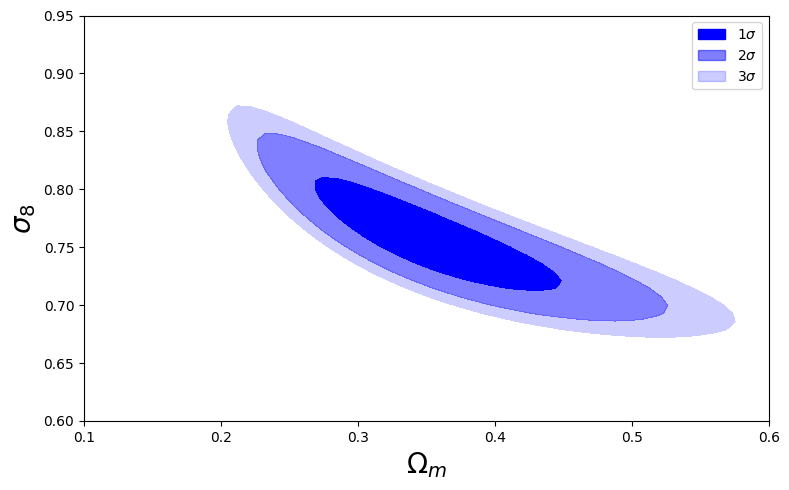

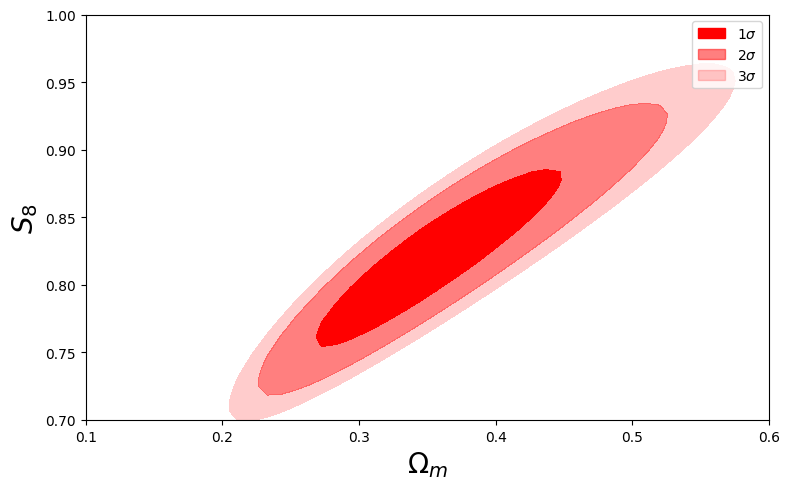

In [9]:
nb_points_distrib = 50

omega_m_list = np.linspace(0.1, 0.6, nb_points_distrib)
sigma_8_list = np.linspace(0.6, 0.95, nb_points_distrib)
s_8_list = np.linspace(0.7, 1.0, nb_points_distrib)

chi2_grid_plot1= np.zeros((nb_points_distrib, nb_points_distrib))
chi2_grid_plot2 = np.zeros((nb_points_distrib, nb_points_distrib))

for i, omegam in enumerate(omega_m_list):
    for j, sigma8 in enumerate(sigma_8_list):
        chi2_grid_plot1[i, j] = calc_chi2_sigma_omega_vectorized(omegam, sigma8)
    for j, s8 in enumerate(s_8_list):
        sigma8 = s8 * np.sqrt(0.3/omegam)
        chi2_grid_plot2[i, j] = calc_chi2_sigma_omega_vectorized(omegam, sigma8)
        
delta_chi2_grid_plot1 = chi2_grid_plot1 - np.min(chi2_grid_plot1)
delta_chi2_grid_plot2 = chi2_grid_plot2 - np.min(chi2_grid_plot2)

levels = [2.30, 6.18, 9.21]

# Confidence Contour plot 1
plt.figure(figsize=(8, 5))

plt.contourf(omega_m_list, sigma_8_list, delta_chi2_grid_plot1.T, levels=[0, levels[0]], colors=['blue'], alpha=1.0)
plt.contourf(omega_m_list, sigma_8_list, delta_chi2_grid_plot1.T, levels=[levels[0], levels[1]], colors=['blue'], alpha=0.5)
plt.contourf(omega_m_list, sigma_8_list, delta_chi2_grid_plot1.T, levels=[levels[1], levels[2]], colors=['blue'], alpha=0.2)

patch1 = mpatches.Patch(color='blue', alpha=1.0, label=r"1$\sigma$")
patch2 = mpatches.Patch(color='blue', alpha=0.5, label=r"2$\sigma$")
patch3 = mpatches.Patch(color='blue', alpha=0.2, label=r"3$\sigma$")

plt.xlabel(r"$\Omega_m$", fontsize=20)
plt.ylabel(r"$\sigma_8$", fontsize=20)
plt.grid(False)
plt.tight_layout()
plt.legend(handles=[patch1, patch2, patch3])
plt.show()

# Confidence contour plot 2
plt.figure(figsize=(8, 5))

plt.contourf(omega_m_list, s_8_list, delta_chi2_grid_plot2.T, levels=[0, levels[0]], colors=['red'], alpha=1.0)
plt.contourf(omega_m_list, s_8_list, delta_chi2_grid_plot2.T, levels=[levels[0], levels[1]], colors=['red'], alpha=0.5)
plt.contourf(omega_m_list, s_8_list, delta_chi2_grid_plot2.T, levels=[levels[1], levels[2]], colors=['red'], alpha=0.2)

patch1 = mpatches.Patch(color='red', alpha=1.0, label=r"1$\sigma$")
patch2 = mpatches.Patch(color='red', alpha=0.5, label=r"2$\sigma$")
patch3 = mpatches.Patch(color='red', alpha=0.2, label=r"3$\sigma$")

plt.xlabel(r"$\Omega_m$", fontsize=20)
plt.ylabel(r"$S_8$", fontsize=20)
plt.grid(False)
plt.tight_layout()
plt.legend(handles=[patch1, patch2, patch3])
plt.show()

#### 2) MCMC confidence contours

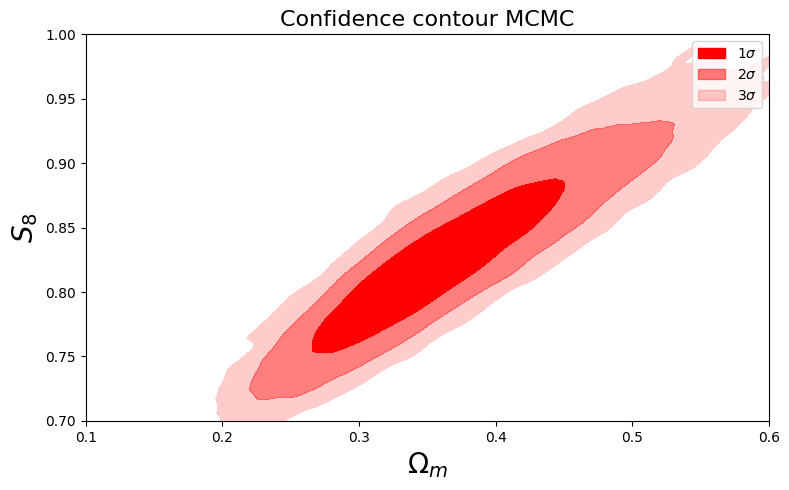

In [10]:
### Confidence contour MCMC
xy = np.vstack([chain_clean[:, 0], chain_clean[:, 1]])
kde = gaussian_kde(xy)

xmin, xmax = 0.1, 0.6
ymin, ymax = 0.7, 1.0
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

Z = kde(positions).reshape(X.shape)

Z_flat = Z.flatten()
Z_sorted = np.sort(Z_flat)[::-1]
cumsum = np.cumsum(Z_sorted)
cumsum /= cumsum[-1]

def find_level(level):
    return Z_sorted[np.searchsorted(cumsum, level)]

levels = [find_level(0.6827), find_level(0.9545), find_level(0.9973)]

plt.figure(figsize=(8, 5))

plt.contourf(X, Y, Z, levels=[levels[2], levels[1]], colors=['red'], alpha=0.2)   # 3σ
plt.contourf(X, Y, Z, levels=[levels[1], levels[0]], colors=['red'], alpha=0.5)   # 2σ
plt.contourf(X, Y, Z, levels=[levels[0], Z.max()], colors=['red'], alpha=1.0)   

patch1 = mpatches.Patch(color='red', alpha=1.0, label=r"1$\sigma$")
patch2 = mpatches.Patch(color='red', alpha=0.5, label=r"2$\sigma$")
patch3 = mpatches.Patch(color='red', alpha=0.2, label=r"3$\sigma$")

plt.xlabel(r"$\Omega_m$", fontsize=20)
plt.ylabel(r"$S_8$", fontsize=20)
plt.title("Confidence contour MCMC", fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.legend(handles=[patch1, patch2, patch3])
plt.show()

# 2) $(\gamma, \Omega_m)$

### Defining functions.

In [11]:
def make_constant_gamma_func(gamma_value):
    return lambda omega_m_z: gamma_value

def calc_chi2_gamma_omega(omega_0, gamma_value):
    gamma_func = make_constant_gamma_func(gamma_value)
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    chi2 = np.sum((growth(z_data.values, gamma_func, omega_0) - fs8_data)**2 / errors**2)
    return chi2

def run_single_chain_gamma_omega(seed):
    return run_single_chain(seed, calc_chi2_gamma_omega)

def mcmc_metropolis_hastings(n_steps, initial_params, proposal_widths, calc_chi2_func):
    current_omega_m, current_gamma = initial_params
    chain = np.zeros((n_steps, 2))
    current_chi2 = calc_chi2_func(current_omega_m, current_gamma)
    
    for i in range(n_steps):
        proposed_omega_m = np.random.normal(current_omega_m, proposal_widths[0])
        proposed_gamma = np.random.normal(current_gamma, proposal_widths[1])
        
        # Physical constraints
        if not (0 < proposed_omega_m < 1 and 0 < proposed_gamma < 2):
            chain[i] = [current_omega_m, current_gamma]
            continue
        
        proposed_chi2 = calc_chi2_func(proposed_omega_m, proposed_gamma)
        
        delta_chi2 = proposed_chi2 - current_chi2
        acceptance_prob = np.exp(-0.5 * delta_chi2)
        
        if np.random.rand() < acceptance_prob:
            current_omega_m, current_gamma = proposed_omega_m, proposed_gamma
            current_chi2 = proposed_chi2
        
        chain[i] = [current_omega_m, current_gamma]
    
    return chain

def run_single_chain(seed, calc_chi2_func):
    np.random.seed(seed)
    return mcmc_metropolis_hastings(
        n_steps=n_steps // n_chains,
        initial_params=[0.3 + 0.01*np.random.randn(), 0.55 + 0.01*np.random.randn()],
        proposal_widths=proposal_widths,
        calc_chi2_func=calc_chi2_func
    )

### Plotting distribution.

             Results             
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│      Ωₘ       │ 0.448 │ 0.129 │
│       γ       │ 0.925 │ 0.330 │
└───────────────┴───────┴───────┘

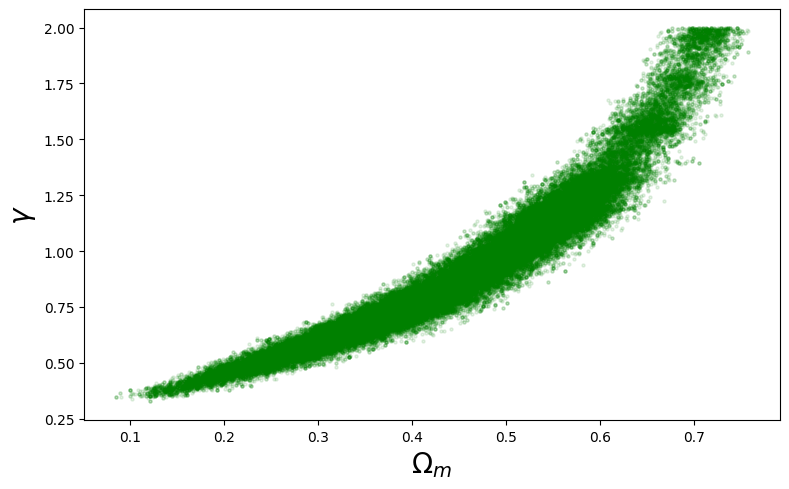

In [12]:
n_steps = 10000 * 10
n_chains = min(cpu_count(), 8)
proposal_widths = [0.02, 0.01]

# Parallelization
with Pool(n_chains) as pool:
    chains = pool.map(run_single_chain_gamma_omega, range(n_chains))

chain_all = np.vstack(chains)
burn_in = 1000
chain_clean = chain_all[burn_in:]

omega_m_mean = np.mean(chain_clean[:, 0])
gamma_mean = np.mean(chain_clean[:, 1])

results = [["Ωₘ", omega_m_mean, np.std(chain_clean[:, 0])], 
           ["γ", gamma_mean, np.std(chain_clean[:, 1])]]
display(results)


plt.figure(figsize=(8, 5))
plt.scatter(chain_clean[:, 0], chain_clean[:, 1], s=5, alpha=0.1, c='green')
plt.xlabel(r"$\Omega_m$", fontsize=20)
plt.ylabel(r"$\gamma$", fontsize=20)
plt.grid(False)
plt.tight_layout()

plt.show()

### Plotting confidence contour.

             Results             
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│      Ωₘ       │ 0.448 │ 0.129 │
│       γ       │ 0.925 │ 0.330 │
└───────────────┴───────┴───────┘

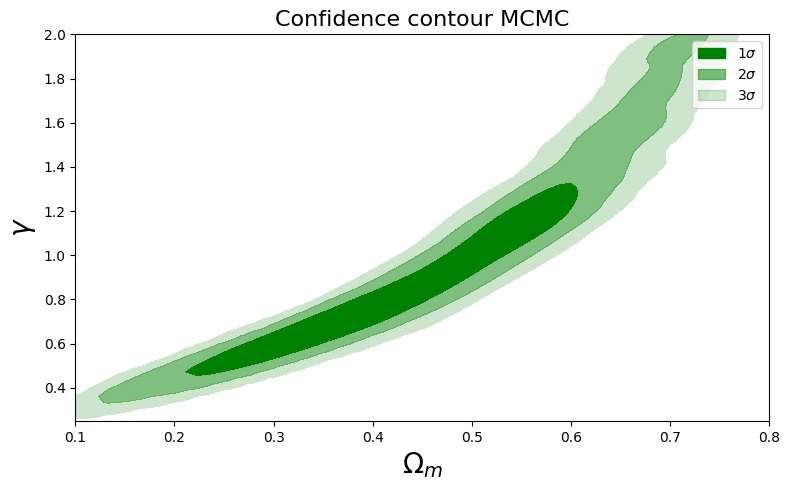

In [13]:
### Confidence contour MCMC
xy = np.vstack([chain_clean[:, 0], chain_clean[:, 1]])

kde = gaussian_kde(xy)

xmin, xmax = 0.1, 0.8
ymin, ymax = 0.25, 2.0
X, Y = np.mgrid[xmin:xmax:64j, ymin:ymax:64j]
positions = np.vstack([X.ravel(), Y.ravel()])

Z = kde(positions).reshape(X.shape)

Z_flat = Z.flatten()
Z_sorted = np.sort(Z_flat)[::-1]
cumsum = np.cumsum(Z_sorted)
cumsum /= cumsum[-1]

def find_level(level):
    return Z_sorted[np.searchsorted(cumsum, level)]

levels = [find_level(0.6827), find_level(0.9545), find_level(0.9973)]

results = [["Ωₘ", omega_m_mean, np.std(chain_clean[:, 0])], 
           ["γ", gamma_mean, np.std(chain_clean[:, 1])]]
display(results)

plt.figure(figsize=(8, 5))

plt.contourf(X, Y, Z, levels=[levels[2], levels[1]], colors=['green'], alpha=0.2)   # 3σ
plt.contourf(X, Y, Z, levels=[levels[1], levels[0]], colors=['green'], alpha=0.5)   # 2σ
plt.contourf(X, Y, Z, levels=[levels[0], Z.max()], colors=['green'], alpha=1.0)   

patch1 = mpatches.Patch(color='green', alpha=1.0, label=r"1$\sigma$")
patch2 = mpatches.Patch(color='green', alpha=0.5, label=r"2$\sigma$")
patch3 = mpatches.Patch(color='green', alpha=0.2, label=r"3$\sigma$")

plt.xlabel(r"$\Omega_m$", fontsize=20)
plt.ylabel(r"$\gamma$", fontsize=20)
plt.title("Confidence contour MCMC", fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.legend(handles=[patch1, patch2, patch3])
plt.show()

### Plotting PDF (fastkde).

             Results             
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│      Ωₘ       │ 0.448 │ 0.129 │
│       γ       │ 0.925 │ 0.330 │
└───────────────┴───────┴───────┘

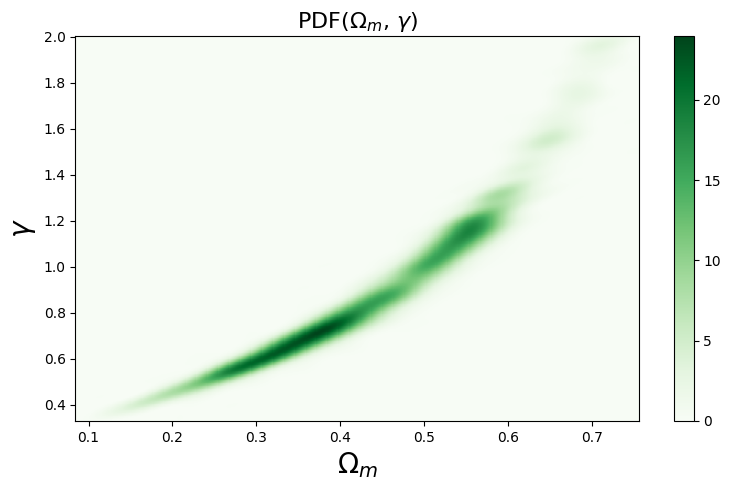

In [14]:
import numpy as np
import fastkde
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Données MCMC
x = chain_clean[:, 0]
y = chain_clean[:, 1]

xmin, xmax = 0.1, 0.8
ymin, ymax = 0.25, 2.0

PDF = fastkde.pdf(x, y, var_names=['Omega_m', 'gamma'], num_points=2**10 + 1)
X, Y = np.meshgrid(PDF['Omega_m'].values, PDF['gamma'].values, indexing='xy')
Z = PDF.values 

results = [["Ωₘ", omega_m_mean, np.std(chain_clean[:, 0])], 
           ["γ", gamma_mean, np.std(chain_clean[:, 1])]]
display(results)

ax = PDF.plot(figsize=(8, 5), cmap=plt.get_cmap('Greens'))
plt.title(r"PDF($\Omega_m$, $\gamma$)", fontsize=16)
plt.xlabel(r"$\Omega_m$", fontsize=20)
plt.ylabel(r"$\gamma$", fontsize=20)
ax.colorbar.set_label('')
plt.tight_layout()
plt.show()

# 3) $(\gamma, \sigma_8)$

### Defining functions

In [15]:
def make_constant_gamma_func(gamma_value):
    return lambda omega_m_z: gamma_value

def calc_chi2_gamma_sigma(sigma_8, gamma_value):
    gamma_func = make_constant_gamma_func(gamma_value)
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    chi2 = np.sum((growth(z_data.values, gamma_func, sigma_8_0 = sigma_8) - fs8_data)**2 / errors**2)
    return chi2

def run_single_chain_gamma_sigma(seed):
    return run_single_chain(seed, calc_chi2_gamma_sigma)

def mcmc_metropolis_hastings(n_steps, initial_params, proposal_widths, calc_chi2_func):
    current_sigma_8, current_gamma = initial_params
    chain = np.zeros((n_steps, 2))
    current_chi2 = calc_chi2_func(current_sigma_8, current_gamma)
    
    for i in range(n_steps):
        proposed_sigma_8 = np.random.normal(current_sigma_8, proposal_widths[0])
        proposed_gamma = np.random.normal(current_gamma, proposal_widths[1])
        
        # Physical constraints
        if not (0 < proposed_sigma_8 < 2 and 0 < proposed_gamma < 2):
            chain[i] = [current_sigma_8, current_gamma]
            continue
        
        proposed_chi2 = calc_chi2_func(proposed_sigma_8, proposed_gamma)
        
        delta_chi2 = proposed_chi2 - current_chi2
        acceptance_prob = np.exp(-0.5 * delta_chi2)
        
        if np.random.rand() < acceptance_prob:
            current_sigma_8, current_gamma = proposed_sigma_8, proposed_gamma
            current_chi2 = proposed_chi2
        
        chain[i] = [current_sigma_8, current_gamma]
    
    return chain

def run_single_chain(seed, calc_chi2_func):
    np.random.seed(seed)
    return mcmc_metropolis_hastings(
        n_steps=n_steps // n_chains,
        initial_params=[0.81 + 0.01*np.random.randn(), 0.55 + 0.01*np.random.randn()],
        proposal_widths=proposal_widths,
        calc_chi2_func=calc_chi2_func
    )

### Plotting distribution

             Results             
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│      σ8       │ 0.745 │ 0.047 │
│       γ       │ 0.479 │ 0.105 │
└───────────────┴───────┴───────┘

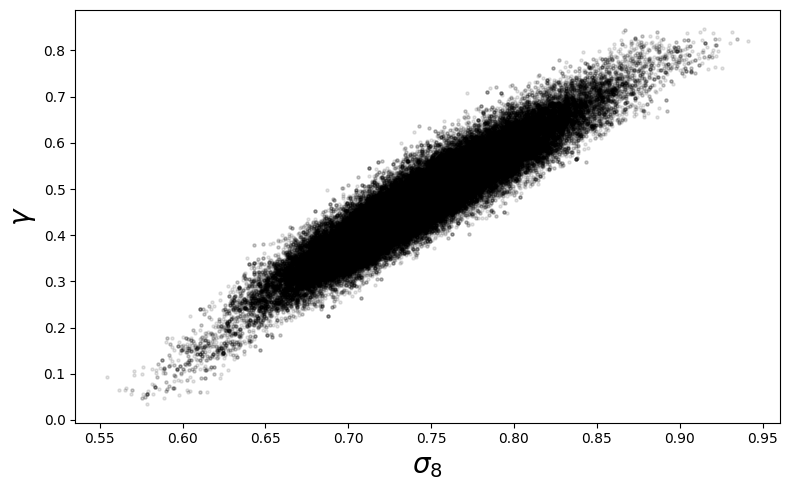

In [16]:
n_steps = 10000 * 10
n_chains = min(cpu_count(), 8)
proposal_widths = [0.02, 0.01]

# Parallelization
with Pool(n_chains) as pool:
    chains = pool.map(run_single_chain_gamma_sigma, range(n_chains))

chain_all = np.vstack(chains)
burn_in = 1000
chain_clean = chain_all[burn_in:]

sigma_8_mean = np.mean(chain_clean[:, 0])
gamma_mean = np.mean(chain_clean[:, 1])

results = [["σ8", sigma_8_mean, np.std(chain_clean[:, 0])], 
           ["γ", gamma_mean, np.std(chain_clean[:, 1])]]
display(results)


plt.figure(figsize=(8, 5))
plt.scatter(chain_clean[:, 0], chain_clean[:, 1], s=5, alpha=0.1, c='k')
plt.xlabel(r"$\sigma_8$", fontsize=20)
plt.ylabel(r"$\gamma$", fontsize=20)
plt.grid(False)
plt.tight_layout()

plt.show()